In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import cv2
import numpy as np
import os

def classify_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not read the image: {image_path}")
        return None

    # Resize image for consistency
    resized_image = cv2.resize(image, (224, 224))

    # Convert image to HSV color space
    hsv_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)

    # Define color thresholds for healthy and unhealthy
    healthy_lower = np.array([35, 40, 40])  # Light green
    healthy_upper = np.array([85, 255, 255])  # Dark green

    unhealthy_lower = np.array([20, 40, 40])  # Yellow to pale green
    unhealthy_upper = np.array([35, 255, 255])  # Pale green

    # Create masks for healthy and unhealthy regions
    healthy_mask = cv2.inRange(hsv_image, healthy_lower, healthy_upper)
    unhealthy_mask = cv2.inRange(hsv_image, unhealthy_lower, unhealthy_upper)

    # Count the number of healthy and unhealthy pixels
    healthy_pixels = np.sum(healthy_mask > 0)
    unhealthy_pixels = np.sum(unhealthy_mask > 0)

    # Classify the image based on the dominant type
    if healthy_pixels > unhealthy_pixels:
        classification = "Healthy"
    else:
        classification = "Unhealthy"

    return classification

# Directory containing drone images
image_directory = "/content/drive/MyDrive/DRONE/Data/TOMATO"

# Initialize counters for healthy and unhealthy images
healthy_count = 0
unhealthy_count = 0

# Iterate through images and classify them
for image_file in os.listdir(image_directory):
    image_path = os.path.join(image_directory, image_file)
    classification = classify_image(image_path)
    if classification is not None:
        print(f"Image: {image_file} -> Classification: {classification}")
        if classification == "Healthy":
            healthy_count += 1
        else:
            unhealthy_count += 1

# Print the summary
print(f"\nTotal Healthy Images: {healthy_count}")
print(f"Total Unhealthy Images: {unhealthy_count}")

Image: image_976.jpg -> Classification: Healthy
Image: image_979.jpg -> Classification: Healthy
Image: image_978.jpg -> Classification: Healthy
Image: image_980.jpg -> Classification: Healthy
Image: image_981.jpg -> Classification: Healthy
Image: image_983.jpg -> Classification: Healthy
Image: image_982.jpg -> Classification: Healthy
Image: image_984.jpg -> Classification: Healthy
Image: image_985.jpg -> Classification: Healthy
Image: image_986.jpg -> Classification: Healthy
Image: image_988.jpg -> Classification: Healthy
Image: image_987.jpg -> Classification: Healthy
Image: image_989.jpg -> Classification: Healthy
Image: image_991.jpg -> Classification: Healthy
Image: image_990.jpg -> Classification: Healthy
Image: image_992.jpg -> Classification: Healthy
Image: image_993.jpg -> Classification: Healthy
Image: image_994.jpg -> Classification: Healthy
Image: image_995.jpg -> Classification: Healthy
Image: image_996.jpg -> Classification: Healthy
Image: image_997.jpg -> Classification: 

In [8]:
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split

def classify_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not read the image: {image_path}")
        return None

    # Resize image for consistency
    resized_image = cv2.resize(image, (224, 224))

    # Convert image to HSV color space
    hsv_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)

    # Define color thresholds for healthy and unhealthy
    healthy_lower = np.array([35, 40, 40])  # Light green
    healthy_upper = np.array([85, 255, 255])  # Dark green

    unhealthy_lower = np.array([20, 40, 40])  # Yellow to pale green
    unhealthy_upper = np.array([35, 255, 255])  # Pale green

    # Create masks for healthy and unhealthy regions
    healthy_mask = cv2.inRange(hsv_image, healthy_lower, healthy_upper)
    unhealthy_mask = cv2.inRange(hsv_image, unhealthy_lower, unhealthy_upper)

    # Count the number of healthy and unhealthy pixels
    healthy_pixels = np.sum(healthy_mask > 0)
    unhealthy_pixels = np.sum(unhealthy_mask > 0)

    # Classify the image based on the dominant type
    if healthy_pixels > unhealthy_pixels:
        classification = "Healthy"
    else:
        classification = "Unhealthy"

    return classification

# Directory containing drone images
image_directory = "/content/drive/MyDrive/DRONE/Data/TOMATO"

# List to store image paths and labels
image_paths = []
labels = []

# Iterate through images and classify them
for image_file in os.listdir(image_directory):
    image_path = os.path.join(image_directory, image_file)
    classification = classify_image(image_path)
    if classification is not None:
        image_paths.append(image_path)
        labels.append(classification)

# Convert labels to numerical format
labels_numeric = [0 if label == "Healthy" else 1 for label in labels]

# Split the data into training and testing sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels_numeric, test_size=0.2, random_state=42)

# Print the split information
print(f"\nTotal Images: {len(image_paths)}")
print(f"Training Images: {len(train_paths)}")
print(f"Testing Images: {len(test_paths)}")



Total Images: 1934
Training Images: 1547
Testing Images: 387


In [9]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load ResNet50 model pre-trained on ImageNet
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Build the complete model by adding custom layers on top of ResNet50
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification (Healthy vs Unhealthy)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Data preprocessing and augmentation
def load_and_preprocess_images(image_paths, labels, target_size=(224, 224)):
    images = []
    for image_path in image_paths:
        image = cv2.imread(image_path)
        image = cv2.resize(image, target_size)
        image = tf.keras.applications.resnet50.preprocess_input(image)  # Preprocess for ResNet
        images.append(image)
    return np.array(images), np.array(labels)

# Split the data into training and testing sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels_numeric, test_size=0.2, random_state=42)

# Load and preprocess images
train_images, train_labels = load_and_preprocess_images(train_paths, train_labels)
test_images, test_labels = load_and_preprocess_images(test_paths, test_labels)

# Train the model
history = model.fit(train_images, train_labels, epochs=10, batch_size=16, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc}")

# Make predictions on the test set
test_predictions = model.predict(test_images)
test_predictions = (test_predictions > 0.5).astype(int)  # Convert to binary (0 or 1)

# Print classification report (Precision, Recall, F1-Score)
print("\nClassification Report:")
print(classification_report(test_labels, test_predictions))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 326s 4s/step - accuracy: 0.8672 - loss: 0.6913 - val_accuracy: 0.9387 - val_loss: 0.1793
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 322s 4s/step - accuracy: 0.9288 - loss: 0.1698 - val_accuracy: 0.9097 - val_loss: 0.3272
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 296s 4s/step - accuracy: 0.9467 - loss: 0.1454 - val_accuracy: 0.9548 - val_loss: 0.1045
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 318s 4s/step - accuracy: 0.9563 - loss: 0.0880 - val_accuracy: 0.9258 - val_loss: 0.1562
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 347s 4s/step - accuracy: 0.9571 - loss: 0.0941 - val_accuracy: 0.9194 - val_loss: 0.2677
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 296s 4s/step - accuracy: 0.9587 - loss: 0.1263 - val_accuracy: 0.9065 - val_loss: 0.2781
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 322s 4s/step - accuracy: 0.9447 - loss: 0.1338 - val_accuracy: 0.9484 - val_loss: 0.1136
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 324s 4s/step - accurac

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


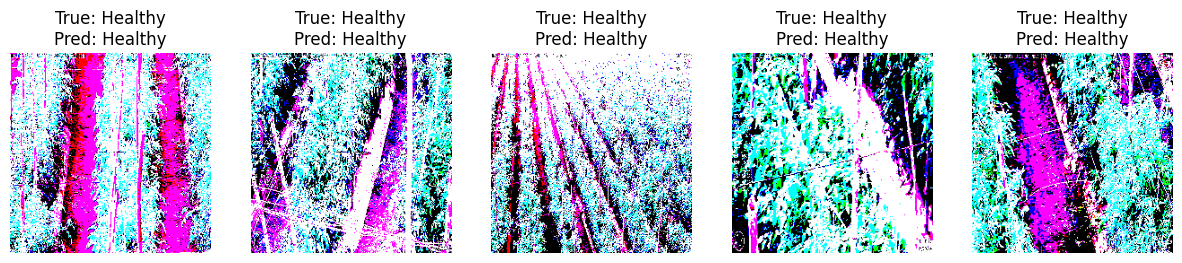

In [10]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Function to display images with true and predicted labels
def display_images_with_labels(images, true_labels, predicted_labels, n=5):
    plt.figure(figsize=(15, 10))
    for i in range(n):
        plt.subplot(1, n, i+1)
        image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for display
        plt.imshow(image)

        true_label = "Healthy" if true_labels[i] == 0 else "Unhealthy"
        pred_label = "Healthy" if predicted_labels[i] == 0 else "Unhealthy"

        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.show()

# Display 5 random images from the test set
n_images = 5
random_indices = np.random.choice(len(test_images), n_images, replace=False)

# Get the corresponding test images and labels
selected_images = test_images[random_indices]
selected_true_labels = test_labels[random_indices]

# Make predictions for these images
selected_predictions = model.predict(selected_images)
selected_predictions = (selected_predictions > 0.5).astype(int)  # Convert to binary (0 or 1)

# Display the selected images with true and predicted labels
display_images_with_labels(selected_images, selected_true_labels, selected_predictions)